In [76]:
import os
from torchvision import datasets, models, transforms
import torch
import torchvision
import numpy as np

# Load images
1. Define a transformer
2. Define a dataloader

Pay special attention to the comments.

In [130]:
train_trans = transforms.Compose([
    transforms.RandomSizedCrop(224), # this is critical as you will otherwise end up with different size tensors
    transforms.ToTensor() # this is needed to get output as tensors
])

val_trans = transforms.Compose([
    transforms.RandomSizedCrop(224), # this is critical as you will otherwise end up with different size tensors
    transforms.ToTensor() # this is needed to get output as tensors
])

In [105]:
# downloaded from https://download.pytorch.org/tutorial/hymenoptera_data.zip
# from http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
data_dir = '/Users/ytsegay/Desktop/hymenoptera_data/'

In [249]:
train_dataset = datasets.ImageFolder(data_dir + 'train', train_trans)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

val_dataset = datasets.ImageFolder(data_dir + 'val', val_trans)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

# Visualize the data you loaded
This is generic enough to move somewhere central for reuse

In [195]:
# once you get the images out of the data loader use this to get a batch out
# make this generic enough
import matplotlib.pyplot as plt

def plot(images, title=None):
    images = images.numpy().transpose(1,2,0)
    plt.figure(figsize=(15,15))
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    # show titles
    if title != None:
        plt.title(title)
    plt.pause(0.001)


# e.g. given a dataloader this is how you would show a batch of images
#inp, classes = next(iter(train_data_loader))
#imgs = torchvision.utils.make_grid(inp)
#labels = [train_dataset.classes[x] for x in classes]
#plot(imgs, labels)

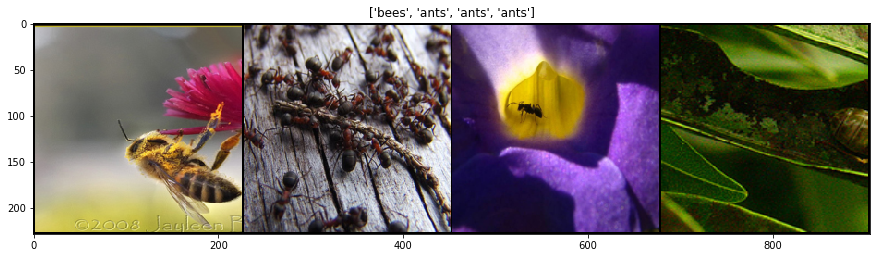

In [133]:
# visualize some train examples 
inp, classes = next(iter(train_data_loader))
imgs = torchvision.utils.make_grid(inp)

labels = [train_dataset.classes[x] for x in classes]
plot(imgs, labels)

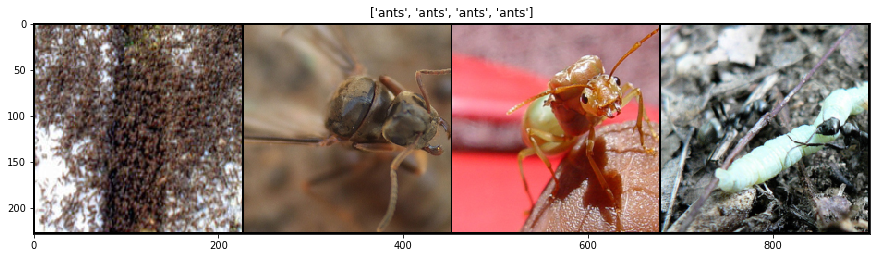

In [228]:
# visualize some train examples 
inp, classes = next(iter(val_data_loader))
imgs = torchvision.utils.make_grid(inp)

labels = [val_dataset.classes[x] for x in classes]
plot(imgs, labels)

# Simple CNN on CPU

In [268]:
import torch.nn as nn
from torch.autograd import Variable

np_epochs = 50

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc = nn.Linear(32*14*14, 2)
        
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        #print(out.size()) # use this to find the structure you will use to generate the size of the FC layer
        
        # flatten before using the fully connected layer
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

cnn = CNN()
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(cnn.parameters(), lr=0.001)

for epoch in range(np_epochs):
    for imgs, classes in train_data_loader:
        imgs = Variable(imgs)
        lbls = Variable(classes)
        
        opt.zero_grad()
        output = cnn(imgs)

        loss = criterion(output, lbls)
        #print(loss.data[0])
        loss.backward()
        opt.step()

# lock the model?
cnn.eval()


CNN (
  (layer1): Sequential (
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (layer2): Sequential (
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (fc): Linear (6272 -> 2)
)

In [293]:
total_pred = 0
total_correct = 0

class_pred_counter = {}
total_pred_counter = {}
correct_pred_counter = {}

corr_pos_pred = 0
pred_pos = 0
lbl_pos = 0

# evaluate the model
for imgs, classes in val_data_loader:
    imgs = Variable(imgs)
    lbls = Variable(classes)
    
    outputs = cnn(imgs)
    #print(outputs.data.numpy())

    # max get the maximum of a row (1) or column (0)
    # max returns the maximum value, and actual max value
    _, predicted =  torch.max(outputs.data, 1)
    correct = (predicted == lbls.data).sum()
    
    for i in range(lbls.data.size()[0]):
        lbl = lbls.data[i]
        pred = predicted[i]
        
        if lbl not in total_pred_counter:
            total_pred_counter[lbl] = 0
            correct_pred_counter[lbl] = 0
    
        if pred not in class_pred_counter:
            class_pred_counter[pred] = 0

        if pred == 1:
            pred_pos += 1
            if pred == lbl:
                corr_pos_pred += 1
        if lbl == 1:
            lbl_pos += 1
        
        total_pred_counter[lbl] += 1
        class_pred_counter[pred] += 1
        correct_pred_counter[lbl] += (lbl == pred)
        
        #print lbl, pred
        
    total_correct += correct 
    total_pred += total

print total_correct
print total_pred 
print
print total_correct*1.0/total_pred

print 'total: ', total_pred_counter
print 'pred:  ', class_pred_counter
print 'corr:  ', correct_pred_counter
print 
print 'corr_pos_labels: ', corr_pos_pred
print 'pos_labels: ', lbl_pos
print 'pos_pred: ', pred_pos


106
153

0.692810457516
total:  {0: 70, 1: 83}
pred:   {0: 103, 1: 50}
corr:   {0: 63, 1: 43}

corr_pos_labels:  43
pos_labels:  83
pos_pred:  50


# Now on GPU
Same as the CPU with all the variables and net

In [ ]:
import torch.nn as nn
from torch.autograd import Variable

np_epochs = 50

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc = nn.Linear(32*14*14, 2)
        
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        #print(out.size()) # use this to find the structure you will use to generate the size of the FC layer
        
        # flatten before using the fully connected layer
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

cnn = CNN()
cnn.cuda()

criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(cnn.parameters(), lr=0.001)

for epoch in range(np_epochs):
    for imgs, classes in train_data_loader:
        imgs = Variable(imgs).cuda()
        lbls = Variable(classes).cuda()
        
        opt.zero_grad()
        output = cnn(imgs)

        loss = criterion(output, lbls)
        #print(loss.data[0])
        loss.backward()
        opt.step()

# lock the model?
cnn.eval()


In [ ]:
total_pred = 0
total_correct = 0

class_pred_counter = {}
total_pred_counter = {}
correct_pred_counter = {}

corr_pos_pred = 0
pred_pos = 0
lbl_pos = 0

# evaluate the model
for imgs, classes in val_data_loader:
    imgs = Variable(imgs).cuda()
    lbls = Variable(classes).cuda()
    
    outputs = cnn(imgs)
    #print(outputs.data.numpy())

    # max get the maximum of a row (1) or column (0)
    # max returns the maximum value, and actual max value
    _, predicted =  torch.max(outputs.data, 1)
    correct = (predicted == lbls.data).sum()
    
    for i in range(lbls.data.size()[0]):
        lbl = lbls.data[i]
        pred = predicted[i]
        
        if lbl not in total_pred_counter:
            total_pred_counter[lbl] = 0
            correct_pred_counter[lbl] = 0
    
        if pred not in class_pred_counter:
            class_pred_counter[pred] = 0

        if pred == 1:
            pred_pos += 1
            if pred == lbl:
                corr_pos_pred += 1
        if lbl == 1:
            lbl_pos += 1
        
        total_pred_counter[lbl] += 1
        class_pred_counter[pred] += 1
        correct_pred_counter[lbl] += (lbl == pred)
        
        #print lbl, pred
        
    total_correct += correct 
    total_pred += total

print total_correct
print total_pred 
print
print total_correct*1.0/total_pred

print 'total: ', total_pred_counter
print 'pred:  ', class_pred_counter
print 'corr:  ', correct_pred_counter
print 
print 'corr_pos_labels: ', corr_pos_pred
print 'pos_labels: ', lbl_pos
print 'pos_pred: ', pred_pos
